# Calculate 'Randomness' of Shots

In [23]:
import numpy as np 
import pandas as pd 
import pickle    
import matplotlib
import matplotlib.pyplot as plt
import math
import sklearn
from sklearn.cluster import KMeans
import json

In [2]:
# load dataset
with open('input/2019fiveVfive.pkl', 'rb') as f:
    game_data = pickle.load(f)

In [3]:
print(game_data[1])

{'result': {'event': 'Period Ready', 'eventCode': 'TOR5', 'eventTypeId': 'PERIOD_READY', 'description': 'Period Ready'}, 'about': {'eventIdx': 1, 'eventId': 5, 'period': 1, 'periodType': 'REGULAR', 'ordinalNum': '1st', 'periodTime': '00:00', 'periodTimeRemaining': '20:00', 'dateTime': '2019-10-02T23:12:31Z', 'goals': {'away': 0, 'home': 0}}, 'coordinates': {}}


### Store all shot coordinates into a dataframe

In [4]:
records = []

for obs in game_data:
    rec_info = {}    # store each record as a dict
    if (obs['result']['event'] == 'Shot'or obs['result']['event'] == 'Goal') and 'coordinates' in obs:
        rec_info['eventType'] = obs['result']['event']
        if 'x' in obs['coordinates']:
                rec_info['x'] = obs['coordinates']['x']
        if 'y' in obs['coordinates']:
                rec_info['y'] = obs['coordinates']['y']
        if obs['result']['event'] == 'Shot':
            for player in obs['players']:
                if player['playerType'] == 'Shooter':
                    rec_info['fullName'] = player['player']['fullName']
        elif obs['result']['event'] == 'Goal':
            for player in obs['players']:
                if player['playerType'] == 'Scorer':
                    rec_info['fullName'] = player['player']['fullName']
        records.append(rec_info)

In [5]:
for i in range(0, 30):
    print(records[i])

{'eventType': 'Goal', 'x': 85.0, 'y': -1.0, 'fullName': 'Brady Tkachuk'}
{'eventType': 'Shot', 'x': 63.0, 'y': -6.0, 'fullName': 'Dylan DeMelo'}
{'eventType': 'Shot', 'x': -59.0, 'y': -20.0, 'fullName': 'Morgan Rielly'}
{'eventType': 'Shot', 'x': -42.0, 'y': -29.0, 'fullName': 'Tyson Barrie'}
{'eventType': 'Shot', 'x': -52.0, 'y': -7.0, 'fullName': 'Tyson Barrie'}
{'eventType': 'Shot', 'x': -38.0, 'y': 38.0, 'fullName': 'Cody Ceci'}
{'eventType': 'Shot', 'x': -76.0, 'y': -14.0, 'fullName': 'Andreas Johnsson'}
{'eventType': 'Shot', 'x': 78.0, 'y': -5.0, 'fullName': 'Colin White'}
{'eventType': 'Shot', 'x': 47.0, 'y': 23.0, 'fullName': 'Thomas Chabot'}
{'eventType': 'Shot', 'x': 67.0, 'y': -20.0, 'fullName': 'Tyler Ennis'}
{'eventType': 'Shot', 'x': 47.0, 'y': -36.0, 'fullName': 'Nikita Zaitsev'}
{'eventType': 'Shot', 'x': 56.0, 'y': 28.0, 'fullName': 'Anthony Duclair'}
{'eventType': 'Shot', 'x': -45.0, 'y': -41.0, 'fullName': 'Morgan Rielly'}
{'eventType': 'Shot', 'x': 50.0, 'y': 22.0, 

In [6]:
df = pd.DataFrame(records)

In [7]:
df.info(verbose=True)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56199 entries, 0 to 56198
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   eventType  56199 non-null  object 
 1   x          56198 non-null  float64
 2   y          56198 non-null  float64
 3   fullName   56199 non-null  object 
dtypes: float64(2), object(2)
memory usage: 1.7+ MB


In [8]:
df.head()

,eventType,x,y,fullName
0,Goal,85.0,-1.0,Brady Tkachuk
1,Shot,63.0,-6.0,Dylan DeMelo
2,Shot,-59.0,-20.0,Morgan Rielly
3,Shot,-42.0,-29.0,Tyson Barrie
4,Shot,-52.0,-7.0,Tyson Barrie


<AxesSubplot:xlabel='x', ylabel='y'>

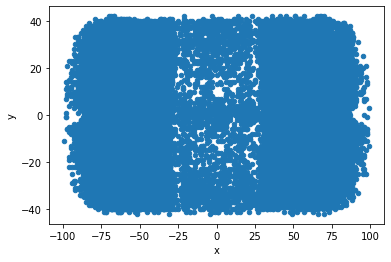

In [9]:
df.plot.scatter(x='x', y='y')

Shots need to all be on the same side of rink...let's rotate coordinates where x is negative

In [10]:
df.loc[df['x'] < 0, 'y'] = df['y'] * -1
df['x'] = df['x'].abs()
df = df[df['x'].notna()]
df.head()

,eventType,x,y,fullName
0,Goal,85.0,-1.0,Brady Tkachuk
1,Shot,63.0,-6.0,Dylan DeMelo
2,Shot,59.0,20.0,Morgan Rielly
3,Shot,42.0,29.0,Tyson Barrie
4,Shot,52.0,7.0,Tyson Barrie


<AxesSubplot:xlabel='x', ylabel='y'>

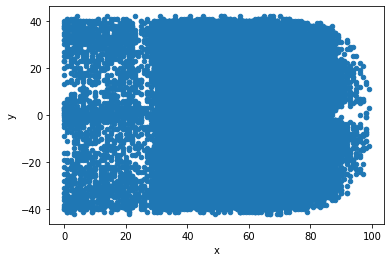

In [11]:
df.plot.scatter(x='x', y='y')

Great! Now all shots will look like they came from the same side of the ice

### Testing metrics to score randomness

##### Try dividing shots into zones and analyze the spread of proportion of shots in each zone

In [12]:
# use kmeans clustering to divide rink into 7 'shot zones'
kmeans = KMeans(n_clusters=7, random_state=0).fit(df[['x','y']])
y_kmeans = kmeans.predict(df[['x','y']])

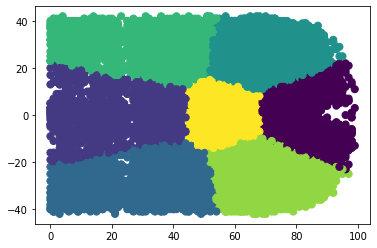

In [13]:
# let's vizualize it to check if our approach makes sense
plt.scatter(df[['x']], df[['y']], c=y_kmeans, s=50, cmap='viridis')

centers = kmeans.cluster_centers_
# plt.scatter(centers[:, 0], centers[:, 1], c='black', s=200, alpha=0.5)

In [14]:
# store labels in dataframe ... ignore warnings
df.loc[:,'shotZone'] = kmeans.labels_

/Users/williamshaw/Projects/NHL/nhl_offense_optimization/env/lib/python3.8/site-packages/pandas/core/indexing.py:1596: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/Users/williamshaw/Projects/NHL/nhl_offense_optimization/env/lib/python3.8/site-packages/pandas/core/indexing.py:1675: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


Let's verify that shotZone labels accurately depict distinct zones on the ice

In [15]:
# player_name = 'Brady Tkachuk'  # give an example player
# player_name = 'Patrick Kane'  # give an example player
# player_name = 'Artemi Panarin'  # give an example player
# player_name = 'Sebastian Aho'  # give an example player
player_name = 'Teuvo Teravainen'  # give an example player

df_single_player = df[df['fullName']== player_name]
df_single_player.head()

,eventType,x,y,fullName,shotZone
362,Shot,50.0,39.0,Teuvo Teravainen,4
370,Shot,80.0,-8.0,Teuvo Teravainen,0
389,Shot,78.0,20.0,Teuvo Teravainen,3
392,Shot,31.0,-31.0,Teuvo Teravainen,2
397,Shot,78.0,35.0,Teuvo Teravainen,3


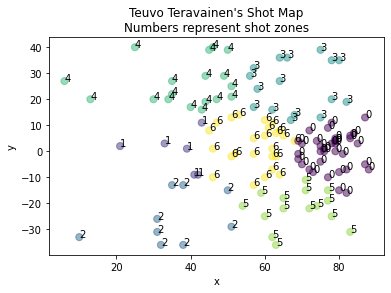

In [16]:
ax = df_single_player.plot.scatter(x='x', y='y', alpha=0.5, c=df_single_player['shotZone'].tolist(), s=50, cmap='viridis')
for i in df_single_player.T.to_dict().values():
    ax.annotate(i['shotZone'], (i['x'], i['y']))
plt.title(player_name + '\'s Shot Map' + '\nNumbers represent shot zones')
plt.show()

Now lets count the number of shots in each zone for all players

In [17]:
# load dataset for player stats data
with open('input/2019evStats.pkl', 'rb') as f:
    player_stats = pickle.load(f)
    
print(len(player_stats))

781


In [18]:
# verify we loaded correct data
import pprint
pprint.pprint(player_stats)

{'Aaron Dell': {'assists': 0, 'goals': 0},
 'Aaron Ekblad': {'assists': 28, 'goals': 5},
 'Adam Boqvist': {'assists': 7, 'goals': 4},
 'Adam Erne': {'assists': 3, 'goals': 2},
 'Adam Fox': {'assists': 21, 'goals': 7},
 'Adam Gaudette': {'assists': 13, 'goals': 8},
 'Adam Henrique': {'assists': 13, 'goals': 21},
 'Adam Larsson': {'assists': 5, 'goals': 1},
 'Adam Lowry': {'assists': 5, 'goals': 3},
 'Adam Pelech': {'assists': 6, 'goals': 1},
 'Adam Ruzicka': {'assists': 0, 'goals': 0},
 'Adin Hill': {'assists': 0, 'goals': 0},
 'Adrian Kempe': {'assists': 11, 'goals': 8},
 'Alec Martinez': {'assists': 9, 'goals': 3},
 'Aleksander Barkov': {'assists': 27, 'goals': 13},
 'Aleksi Saarela': {'assists': 1, 'goals': 2},
 'Alex Biega': {'assists': 3, 'goals': 0},
 'Alex Chiasson': {'assists': 6, 'goals': 5},
 'Alex DeBrincat': {'assists': 20, 'goals': 8},
 'Alex Galchenyuk': {'assists': 11, 'goals': 7},
 'Alex Goligoski': {'assists': 19, 'goals': 2},
 'Alex Iafallo': {'assists': 23, 'goals': 1

 'Sam Reinhart': {'assists': 21, 'goals': 17},
 'Sam Steel': {'assists': 9, 'goals': 5},
 'Sami Niku': {'assists': 5, 'goals': 0},
 'Sami Vatanen': {'assists': 7, 'goals': 4},
 'Sammy Blais': {'assists': 7, 'goals': 6},
 'Samuel Girard': {'assists': 18, 'goals': 3},
 'Scott Harrington': {'assists': 7, 'goals': 1},
 'Scott Laughton': {'assists': 12, 'goals': 13},
 'Scott Mayfield': {'assists': 6, 'goals': 5},
 'Scott Wedgewood': {'assists': 0, 'goals': 0},
 'Sean Couturier': {'assists': 27, 'goals': 21},
 'Sean Kuraly': {'assists': 14, 'goals': 6},
 'Sean Monahan': {'assists': 17, 'goals': 16},
 'Sebastian Aho': {'assists': 18, 'goals': 26},
 'Semyon Varlamov': {'assists': 0, 'goals': 0},
 'Sergei Bobrovsky': {'assists': 0, 'goals': 0},
 'Seth Jones': {'assists': 16, 'goals': 4},
 'Shane Bowers': {'assists': 0, 'goals': 0},
 'Shayne Gostisbehere': {'assists': 3, 'goals': 3},
 'Shea Theodore': {'assists': 15, 'goals': 13},
 'Shea Weber': {'assists': 16, 'goals': 12},
 'Sidney Crosby': {'

In [19]:
# append dict with attribute that counts number of shots in specified zone
for player in player_stats:
    player_stats[player]['zone0'] = 0  
    player_stats[player]['zone1'] = 0
    player_stats[player]['zone2'] = 0
    player_stats[player]['zone3'] = 0
    player_stats[player]['zone4'] = 0
    player_stats[player]['zone5'] = 0
    player_stats[player]['zone6'] = 0

# loop through each record in the df, increment player and shot zone for each record
for i in df.T.to_dict().values():
    name = i['fullName']
    zone = 'zone' + str(i['shotZone'])
    if name in player_stats:
        player_stats[name][zone] = player_stats[name][zone] + 1

In [20]:
# Verify counting was roughly correct
player_stats['Sebastian Aho']

{'goals': 26,
 'assists': 18,
 'zone0': 64,
 'zone1': 4,
 'zone2': 4,
 'zone3': 23,
 'zone4': 6,
 'zone5': 17,
 'zone6': 17}

In [24]:
# Save to dataset
pprint.pprint(player_stats)
with open('./input/2019statsAndShotLoc.json', 'w') as fp:
    json.dump(player_stats, fp)

{'Aaron Dell': {'assists': 0,
                'goals': 0,
                'zone0': 0,
                'zone1': 0,
                'zone2': 0,
                'zone3': 0,
                'zone4': 0,
                'zone5': 0,
                'zone6': 0},
 'Aaron Ekblad': {'assists': 28,
                  'goals': 5,
                  'zone0': 17,
                  'zone1': 8,
                  'zone2': 41,
                  'zone3': 7,
                  'zone4': 11,
                  'zone5': 20,
                  'zone6': 17},
 'Adam Boqvist': {'assists': 7,
                  'goals': 4,
                  'zone0': 2,
                  'zone1': 6,
                  'zone2': 9,
                  'zone3': 4,
                  'zone4': 1,
                  'zone5': 8,
                  'zone6': 6},
 'Adam Erne': {'assists': 3,
               'goals': 2,
               'zone0': 23,
               'zone1': 6,
               'zone2': 3,
               'zone3': 8,
               'zone4': 4,
 

                     'zone1': 2,
                     'zone2': 2,
                     'zone3': 13,
                     'zone4': 6,
                     'zone5': 8,
                     'zone6': 8},
 'Barrett Hayton': {'assists': 3,
                    'goals': 1,
                    'zone0': 15,
                    'zone1': 1,
                    'zone2': 0,
                    'zone3': 5,
                    'zone4': 1,
                    'zone5': 2,
                    'zone6': 1},
 'Ben Bishop': {'assists': 1,
                'goals': 0,
                'zone0': 0,
                'zone1': 0,
                'zone2': 0,
                'zone3': 0,
                'zone4': 0,
                'zone5': 0,
                'zone6': 0},
 'Ben Chiarot': {'assists': 12,
                 'goals': 9,
                 'zone0': 11,
                 'zone1': 13,
                 'zone2': 12,
                 'zone3': 10,
                 'zone4': 52,
                 'zone5': 7,
             

                  'zone1': 0,
                  'zone2': 0,
                  'zone3': 0,
                  'zone4': 0,
                  'zone5': 4,
                  'zone6': 1},
 'Bryan Rust': {'assists': 19,
                'goals': 20,
                'zone0': 54,
                'zone1': 2,
                'zone2': 5,
                'zone3': 7,
                'zone4': 2,
                'zone5': 22,
                'zone6': 24},
 'Buddy Robinson': {'assists': 0,
                    'goals': 1,
                    'zone0': 5,
                    'zone1': 0,
                    'zone2': 1,
                    'zone3': 0,
                    'zone4': 0,
                    'zone5': 0,
                    'zone6': 0},
 'Byron Froese': {'assists': 0,
                  'goals': 0,
                  'zone0': 0,
                  'zone1': 0,
                  'zone2': 0,
                  'zone3': 0,
                  'zone4': 0,
                  'zone5': 0,
                  'zone6':

                    'zone1': 18,
                    'zone2': 63,
                    'zone3': 12,
                    'zone4': 17,
                    'zone5': 21,
                    'zone6': 4},
 'Colton Sceviour': {'assists': 10,
                     'goals': 6,
                     'zone0': 26,
                     'zone1': 5,
                     'zone2': 5,
                     'zone3': 15,
                     'zone4': 6,
                     'zone5': 29,
                     'zone6': 9},
 'Colton Sissons': {'assists': 6,
                    'goals': 8,
                    'zone0': 24,
                    'zone1': 0,
                    'zone2': 0,
                    'zone3': 3,
                    'zone4': 1,
                    'zone5': 10,
                    'zone6': 8},
 'Connor Brown': {'assists': 24,
                  'goals': 13,
                  'zone0': 47,
                  'zone1': 6,
                  'zone2': 13,
                  'zone3': 17,
                  

                    'zone0': 25,
                    'zone1': 1,
                    'zone2': 1,
                    'zone3': 6,
                    'zone4': 5,
                    'zone5': 7,
                    'zone6': 5},
 'Drew Doughty': {'assists': 18,
                  'goals': 2,
                  'zone0': 4,
                  'zone1': 11,
                  'zone2': 28,
                  'zone3': 6,
                  'zone4': 11,
                  'zone5': 6,
                  'zone6': 5},
 'Dryden Hunt': {'assists': 4,
                 'goals': 0,
                 'zone0': 12,
                 'zone1': 1,
                 'zone2': 1,
                 'zone3': 8,
                 'zone4': 3,
                 'zone5': 4,
                 'zone6': 4},
 'Duncan Keith': {'assists': 15,
                  'goals': 1,
                  'zone0': 3,
                  'zone1': 9,
                  'zone2': 14,
                  'zone3': 7,
                  'zone4': 41,
                 

                  'zone0': 0,
                  'zone1': 4,
                  'zone2': 13,
                  'zone3': 0,
                  'zone4': 0,
                  'zone5': 5,
                  'zone6': 0},
 'Gustav Forsling': {'assists': 0,
                     'goals': 0,
                     'zone0': 0,
                     'zone1': 0,
                     'zone2': 0,
                     'zone3': 0,
                     'zone4': 0,
                     'zone5': 0,
                     'zone6': 0},
 'Gustav Lindstrom': {'assists': 0,
                      'goals': 0,
                      'zone0': 1,
                      'zone1': 0,
                      'zone2': 3,
                      'zone3': 0,
                      'zone4': 2,
                      'zone5': 1,
                      'zone6': 1},
 'Hampus Lindholm': {'assists': 12,
                     'goals': 1,
                     'zone0': 1,
                     'zone1': 6,
                     'zone2': 7,
           

 'Jaroslav Halak': {'assists': 2,
                    'goals': 0,
                    'zone0': 0,
                    'zone1': 0,
                    'zone2': 0,
                    'zone3': 0,
                    'zone4': 0,
                    'zone5': 0,
                    'zone6': 0},
 'Jarred Tinordi': {'assists': 3,
                    'goals': 1,
                    'zone0': 1,
                    'zone1': 1,
                    'zone2': 0,
                    'zone3': 1,
                    'zone4': 15,
                    'zone5': 1,
                    'zone6': 0},
 'Jason Demers': {'assists': 10,
                  'goals': 0,
                  'zone0': 4,
                  'zone1': 3,
                  'zone2': 31,
                  'zone3': 0,
                  'zone4': 1,
                  'zone5': 12,
                  'zone6': 1},
 'Jason Dickinson': {'assists': 11,
                     'goals': 9,
                     'zone0': 36,
                     'zone1': 4,
     

                 'zone0': 3,
                 'zone1': 3,
                 'zone2': 30,
                 'zone3': 0,
                 'zone4': 6,
                 'zone5': 15,
                 'zone6': 3},
 'Josh Morrissey': {'assists': 13,
                    'goals': 4,
                    'zone0': 5,
                    'zone1': 15,
                    'zone2': 9,
                    'zone3': 16,
                    'zone4': 42,
                    'zone5': 3,
                    'zone6': 7},
 'Josh Norris': {'assists': 0,
                 'goals': 0,
                 'zone0': 1,
                 'zone1': 0,
                 'zone2': 0,
                 'zone3': 3,
                 'zone4': 0,
                 'zone5': 1,
                 'zone6': 2},
 'Jujhar Khaira': {'assists': 4,
                   'goals': 6,
                   'zone0': 21,
                   'zone1': 5,
                   'zone2': 3,
                   'zone3': 18,
                   'zone4': 8,
              

                 'zone5': 0,
                 'zone6': 0},
 'Marco Scandella': {'assists': 9,
                     'goals': 4,
                     'zone0': 5,
                     'zone1': 11,
                     'zone2': 4,
                     'zone3': 14,
                     'zone4': 30,
                     'zone5': 4,
                     'zone6': 4},
 'Marcus Foligno': {'assists': 14,
                    'goals': 11,
                    'zone0': 39,
                    'zone1': 1,
                    'zone2': 5,
                    'zone3': 13,
                    'zone4': 6,
                    'zone5': 5,
                    'zone6': 11},
 'Marcus Hogberg': {'assists': 0,
                    'goals': 0,
                    'zone0': 0,
                    'zone1': 0,
                    'zone2': 0,
                    'zone3': 0,
                    'zone4': 0,
                    'zone5': 0,
                    'zone6': 0},
 'Marcus Johansson': {'assists': 16,
              

                 'goals': 0,
                 'zone0': 3,
                 'zone1': 7,
                 'zone2': 11,
                 'zone3': 12,
                 'zone4': 32,
                 'zone5': 0,
                 'zone6': 4},
 'Mike Smith': {'assists': 0,
                'goals': 0,
                'zone0': 0,
                'zone1': 0,
                'zone2': 0,
                'zone3': 0,
                'zone4': 0,
                'zone5': 0,
                'zone6': 0},
 'Mikey Anderson': {'assists': 0,
                    'goals': 1,
                    'zone0': 0,
                    'zone1': 1,
                    'zone2': 2,
                    'zone3': 2,
                    'zone4': 4,
                    'zone5': 0,
                    'zone6': 0},
 'Mikhail Grigorenko': {'assists': 0,
                        'goals': 0,
                        'zone0': 0,
                        'zone1': 0,
                        'zone2': 0,
                        'zone3': 0,


                  'goals': 4,
                  'zone0': 6,
                  'zone1': 18,
                  'zone2': 6,
                  'zone3': 21,
                  'zone4': 42,
                  'zone5': 6,
                  'zone6': 15},
 'Noel Acciari': {'assists': 7,
                  'goals': 19,
                  'zone0': 43,
                  'zone1': 4,
                  'zone2': 4,
                  'zone3': 10,
                  'zone4': 3,
                  'zone5': 14,
                  'zone6': 21},
 'Nolan Patrick': {'assists': 0,
                   'goals': 0,
                   'zone0': 0,
                   'zone1': 0,
                   'zone2': 0,
                   'zone3': 0,
                   'zone4': 0,
                   'zone5': 0,
                   'zone6': 0},
 'Oliver Bjorkstrand': {'assists': 12,
                        'goals': 18,
                        'zone0': 49,
                        'zone1': 5,
                        'zone2': 7,
          

                   'goals': 1,
                   'zone0': 0,
                   'zone1': 2,
                   'zone2': 1,
                   'zone3': 7,
                   'zone4': 7,
                   'zone5': 0,
                   'zone6': 1},
 'Reilly Smith': {'assists': 23,
                  'goals': 21,
                  'zone0': 57,
                  'zone1': 1,
                  'zone2': 4,
                  'zone3': 31,
                  'zone4': 5,
                  'zone5': 22,
                  'zone6': 16},
 'Richard Panik': {'assists': 13,
                   'goals': 9,
                   'zone0': 20,
                   'zone1': 7,
                   'zone2': 4,
                   'zone3': 13,
                   'zone4': 3,
                   'zone5': 14,
                   'zone6': 6},
 'Rickard Rakell': {'assists': 18,
                    'goals': 14,
                    'zone0': 66,
                    'zone1': 5,
                    'zone2': 8,
                    '

 'Trevor Moore': {'assists': 3,
                  'goals': 6,
                  'zone0': 24,
                  'zone1': 2,
                  'zone2': 1,
                  'zone3': 13,
                  'zone4': 2,
                  'zone5': 6,
                  'zone6': 7},
 'Trevor van Riemsdyk': {'assists': 7,
                         'goals': 1,
                         'zone0': 0,
                         'zone1': 6,
                         'zone2': 35,
                         'zone3': 2,
                         'zone4': 0,
                         'zone5': 8,
                         'zone6': 3},
 'Tristan Jarry': {'assists': 0,
                   'goals': 0,
                   'zone0': 0,
                   'zone1': 0,
                   'zone2': 0,
                   'zone3': 0,
                   'zone4': 0,
                   'zone5': 0,
                   'zone6': 0},
 'Troy Grosenick': {'assists': 0,
                    'goals': 0,
                    'zone0': 0,
        

In [38]:
# df for goals, assists, and number of shots in each zone
df_stats = pd.DataFrame(player_stats).transpose()
df_stats['totalShots'] = df_stats['zone0'] + df_stats['zone1'] + df_stats['zone2'] + df_stats['zone3'] + df_stats['zone4'] + df_stats['zone5'] + df_stats['zone6']
df_stats.head()

,goals,assists,zone0,zone1,zone2,zone3,zone4,zone5,zone6,totalShots
Sami Vatanen,4,7,5,13,22,4,7,5,3,59
Eric Comrie,0,0,0,0,0,0,0,0,0,0
Jesper Bratt,15,11,36,3,5,13,9,9,11,86
Travis Zajac,7,14,26,5,3,4,2,13,8,61
P.K. Subban,5,7,5,8,59,7,15,6,11,111


In [39]:
# df for only shots in each zone ****use ALL zones
df_zones = df_stats[['zone0', 'zone1', 'zone2', 'zone3', 'zone4', 'zone5', 'zone6']].transpose()
print('Num Shots from each zone')
print(df_zones['Sebastian Aho'])
print(df_zones['Teuvo Teravainen'])
print()

# calculate variances
test = pd.DataFrame([df_zones.mean(), df_zones.std(), df_zones.var()], index=['Mean', 'Std. dev', 'Variance'])
print('Variances when using all zones in calculation')
print(test['Sebastian Aho'])
print(test['Teuvo Teravainen'])
print()

Num Shots from each zone
zone0    64
zone1     4
zone2     4
zone3    23
zone4     6
zone5    17
zone6    17
Name: Sebastian Aho, dtype: int64
zone0    35
zone1     6
zone2     9
zone3    16
zone4    18
zone5    15
zone6    25
Name: Teuvo Teravainen, dtype: int64

Variances when using all zones in calculation
Mean         19.285714
Std. dev     21.084863
Variance    444.571429
Name: Sebastian Aho, dtype: float64
Mean        17.714286
Std. dev     9.793098
Variance    95.904762
Name: Teuvo Teravainen, dtype: float64



In [40]:
# df for only shots in each zone ****ONLY use zones0, 2, 3, and 6 -- zones below faceoff dots
df_zones = df_stats[['zone0', 'zone2', 'zone3', 'zone6']].transpose()
print('Num Shots from each zone')
print(df_zones['Sebastian Aho'])
print(df_zones['Teuvo Teravainen'])
print()

# calculate variances
test = pd.DataFrame([df_zones.mean(), df_zones.std(), df_zones.var()], index=['Mean', 'Std. dev', 'Variance'])
print('Variances when using all zones in calculation')
print(test['Sebastian Aho'])
print(test['Teuvo Teravainen'])
print()

Num Shots from each zone
zone0    64
zone2     4
zone3    23
zone6    17
Name: Sebastian Aho, dtype: int64
zone0    35
zone2     9
zone3    16
zone6    25
Name: Teuvo Teravainen, dtype: int64

Variances when using all zones in calculation
Mean         27.000000
Std. dev     25.910101
Variance    671.333333
Name: Sebastian Aho, dtype: float64
Mean         21.250000
Std. dev     11.265730
Variance    126.916667
Name: Teuvo Teravainen, dtype: float64



So far, I am not sure if we should caclulate shot variance using all zones or a select number of zones. We will return to this thought when we test line combinations in the file 'stat_counter.ipynb'.

In [50]:
# also calculate proportion of shots in each zone ... this might be useful later
for i in range(0,7):
    percent_zone_x = 'percent_zone' + str(i)
    zone_x = 'zone' + str(i)
    df_stats[percent_zone_x] = df_stats[zone_x] / df_stats['totalShots']

# drop rows where percent == NaN
df_stats = df_stats[df_stats['percent_zone0'].notna()]
df_stats

,goals,assists,zone0,zone1,zone2,zone3,zone4,zone5,zone6,totalShots,percent_zone0,percent_zone1,percent_zone2,percent_zone3,percent_zone4,percent_zone5,percent_zone6
Sami Vatanen,4,7,5,13,22,4,7,5,3,59,0.084746,0.220339,0.372881,0.067797,0.118644,0.084746,0.050847
Jesper Bratt,15,11,36,3,5,13,9,9,11,86,0.418605,0.034884,0.058140,0.151163,0.104651,0.104651,0.127907
Travis Zajac,7,14,26,5,3,4,2,13,8,61,0.426230,0.081967,0.049180,0.065574,0.032787,0.213115,0.131148
P.K. Subban,5,7,5,8,59,7,15,6,11,111,0.045045,0.072072,0.531532,0.063063,0.135135,0.054054,0.099099
Kyle Palmieri,14,13,42,4,10,15,4,21,17,113,0.371681,0.035398,0.088496,0.132743,0.035398,0.185841,0.150442
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomas Nosek,7,7,51,1,1,16,5,9,7,90,0.566667,0.011111,0.011111,0.177778,0.055556,0.100000,0.077778
Alex Tuch,6,5,29,4,8,18,2,18,10,89,0.325843,0.044944,0.089888,0.202247,0.022472,0.202247,0.112360
Nicolas Roy,4,5,19,3,2,4,0,7,5,40,0.475000,0.075000,0.050000,0.100000,0.000000,0.175000,0.125000
Cody Glass,4,2,15,1,0,6,3,13,9,47,0.319149,0.021277,0.000000,0.127660,0.063830,0.276596,0.191489


In [55]:
# verify that proportions add to 100%
# ignore warnings
test = df_stats
test['total_percent'] = 0
for i in range(0,7):
    percent_zone_x = 'percent_zone' + str(i)
    test['total_percent'] = test['total_percent'] + test[percent_zone_x]

test

<ipython-input-55-5863904b21be>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['total_percent'] = 0
<ipython-input-55-5863904b21be>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test['total_percent'] = test['total_percent'] + test[percent_zone_x]


,goals,assists,zone0,zone1,zone2,zone3,zone4,zone5,zone6,totalShots,percent_zone0,percent_zone1,percent_zone2,percent_zone3,percent_zone4,percent_zone5,percent_zone6,total_percent
Sami Vatanen,4,7,5,13,22,4,7,5,3,59,0.084746,0.220339,0.372881,0.067797,0.118644,0.084746,0.050847,1.0
Jesper Bratt,15,11,36,3,5,13,9,9,11,86,0.418605,0.034884,0.058140,0.151163,0.104651,0.104651,0.127907,1.0
Travis Zajac,7,14,26,5,3,4,2,13,8,61,0.426230,0.081967,0.049180,0.065574,0.032787,0.213115,0.131148,1.0
P.K. Subban,5,7,5,8,59,7,15,6,11,111,0.045045,0.072072,0.531532,0.063063,0.135135,0.054054,0.099099,1.0
Kyle Palmieri,14,13,42,4,10,15,4,21,17,113,0.371681,0.035398,0.088496,0.132743,0.035398,0.185841,0.150442,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Tomas Nosek,7,7,51,1,1,16,5,9,7,90,0.566667,0.011111,0.011111,0.177778,0.055556,0.100000,0.077778,1.0
Alex Tuch,6,5,29,4,8,18,2,18,10,89,0.325843,0.044944,0.089888,0.202247,0.022472,0.202247,0.112360,1.0
Nicolas Roy,4,5,19,3,2,4,0,7,5,40,0.475000,0.075000,0.050000,0.100000,0.000000,0.175000,0.125000,1.0
Cody Glass,4,2,15,1,0,6,3,13,9,47,0.319149,0.021277,0.000000,0.127660,0.063830,0.276596,0.191489,1.0


### Save dataset to pickel file

In [56]:
year = '2019'
with open('./input/'+year+'evStatsWithShotZones.pkl', 'wb') as f:
    pickle.dump(df_stats, f, pickle.HIGHEST_PROTOCOL)